In [1]:
import torch
import matplotlib.pyplot as plt
import ESN
import time
import numpy as np
import json
import util

In [2]:
torch.set_default_device("cuda:0")
torch.set_default_dtype(torch.double)

In [4]:
fn = input("set file name : ")


set file name :  100K_lin_normal


In [5]:
# Parameters
Two,Ttrain = 2000,1000000
N = 10
rho=0.6
C = 0

dim = 1
sigma = 1.0
N_d = int(N * dim)
#N_d = 
shftreg = False
idwin = False
actf = "identity"
#actf = "tanh"
dist="normal"
#dist="uniform"

rseed=0

setting = {"input dim":dim,"Two":Two, "Ttrain":Ttrain,"sigma":sigma,"rseed" : rseed, 
            "Nodes":N_d,"uC":C,"rho":rho, "actf":actf,"identical Win":idwin,"input dist":dist}


# store experiment setting 
with open('./experiments/settings/'+fn+'_s.txt', 'x') as fp:
    data = json.dump(setting,fp)

print("settings stored:",setting)

settings stored: {'input dim': 1, 'Two': 2000, 'Ttrain': 1000000, 'sigma': 1.0, 'rseed': 0, 'Nodes': 10, 'uC': 0, 'rho': 0.6, 'actf': 'identity', 'identical Win': False, 'input dist': 'normal'}


In [7]:
## create input
if 1:
    fn_in = "100K_nl_normal"
    u_sym = torch.load(f"./experiments/inputs/{fn_in}_i.pt")
    
if 0:
    torch.manual_seed(0)
    u_asym = torch.rand(dim, Two + Ttrain)
    #u_sym = u_asym
    u_sym = 2 * u_asym - 1

if 0:
    torch.manual_seed(0)
    u_sym = torch.normal(0,1, (1,Two + Ttrain),device="cuda:0")

if 0: torch.save(u_sym,f"./experiments/inputs/{fn}_i.pt")



/tmp/ipykernel_246864/635305064.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  u = torch.load(f"./experiments/inputs/{fn_in}_i.pt")


In [9]:
## construct ESN model
## run and washout 
esn = ESN.ESN_mult(N_d, rho=rho,uC=C, dim=dim,idWin = idwin,sigma =sigma,rseed=rseed)
print("running ESN ...")
st = time.time()
Xwo = esn.run_washout(u_sym, Two, actf=actf)
print("runtime :",time.time()-st)

torch.save(Xwo,f"./experiments/datamatrices/{fn}_d.pt")



runtime : 123.82857275009155


In [10]:
""" calculate MEMORY CAPACITY """
if setting["identical Win"]:
    maxtau = int(N*1.5) 
else : maxtau =  int(N_d/dim *2) 

""" tweak maxtau here """
##
maxtau=int(N*4)

st=time.time()
#mfs = ESN.MC_cSVD_old(u_sym, Xwo, maxtau)
#mfs = ESN.MC_cSVD(u_sym, Xwo, maxtau)
mfs_raw, mfs_lin, mfs_rev, sur_value = ESN.MC_cSVD(u_sym, Xwo, maxtau,ret_all=True)
mfs = mfs_rev
print("mc calc time :",time.time()-st)
print("total MC :",float(torch.sum(mfs)))
torch.save(mfs,f"./experiments/mfs/{fn}_mf.pt")
torch.save(mfs_raw,f"./experiments/mfs/{fn}_raw.pt")
torch.save(sur_value,f"./experiments/mfs/{fn}_sur.pt")

mc calc time : 0.21552634239196777
total MC : 9.997677751503375


In [11]:
## calculate ipc

## create target functions
if 0:
    with open('./experiments/settings/'+fn+'_s.txt', 'r') as fp:
        setting = json.load(fp)
    u_sym = torch.load('./experiments/inputs/'+fn+'_i.pt',weights_only=False)
    Xwo = torch.load('./experiments/datamatrices/'+fn+'_d.pt',weights_only=False)
    Two = setting["Two"]
    print("load complete")
    
## set max delay, degree
maxdd=[[1,20],
       [2,10],
       [3,10],
       [4,7],
       [5,7],
       [6,3],
       [7,3]]


st = time.time()
target_info = ESN.make_targets(u_sym,maxdd,Two=Two,poly="hermite")
ti=target_info
print(r"target creation time:%.3f s"%(time.time()-st))

torch.save(target_info,f"./experiments/target_info/{fn}_ti.pt")



basis table creation:0.003 s
1 degree:20 target functions
2 degree:55 target functions
3 degree:220 target functions
4 degree:210 target functions
5 degree:462 target functions
6 degree:28 target functions
7 degree:36 target functions
Total of 1031 bases
 7/7 degree bases now calculating ...
target creation complete, total of 1031 bases
target creation time:46.841 s


In [5]:
## calculate capacities
#
if 0:
    st = time.time()
    ti = torch.load('./experiments/target_info/'+fn+'_ti.pt',weights_only=False)
    Xwo = torch.load('./experiments/datamatrices/'+fn+'_d.pt',weights_only=False)
    print(r"load time :%.3f s"%(time.time()-st))

    
st = time.time()
raw,thr,thr_scl,rev,sur = ESN.calc_capacity(Xwo,ti.tar_f,ret_all=True,thr_scale=1.2)
print(r"ipc calc time :%.3f s"%(time.time()-st))

cap = thr_scl

ipc=ESN.IPC_w_targetinfo(cap,ti)


torch.save(ipc,f"./experiments/ipcs/{fn}_ipc.pt")
torch.save(raw,f"./experiments/ipcs/{fn}_raw.pt")
torch.save(sur,f"./experiments/ipcs/{fn}_sur.pt")

util.print_ipc(ipc)

ipc calc time :0.382 s
1 deg ipc: 4.303307282441977
2 deg ipc: 9.205923526414141e-05
3 deg ipc: 8.119513189967458
4 deg ipc: 0.0017847577054579946
5 deg ipc: 4.248583243870529
6 deg ipc: 0.0026196185346834882
7 deg ipc: 0.3503089233843068
total ipc: 17.026209075139676


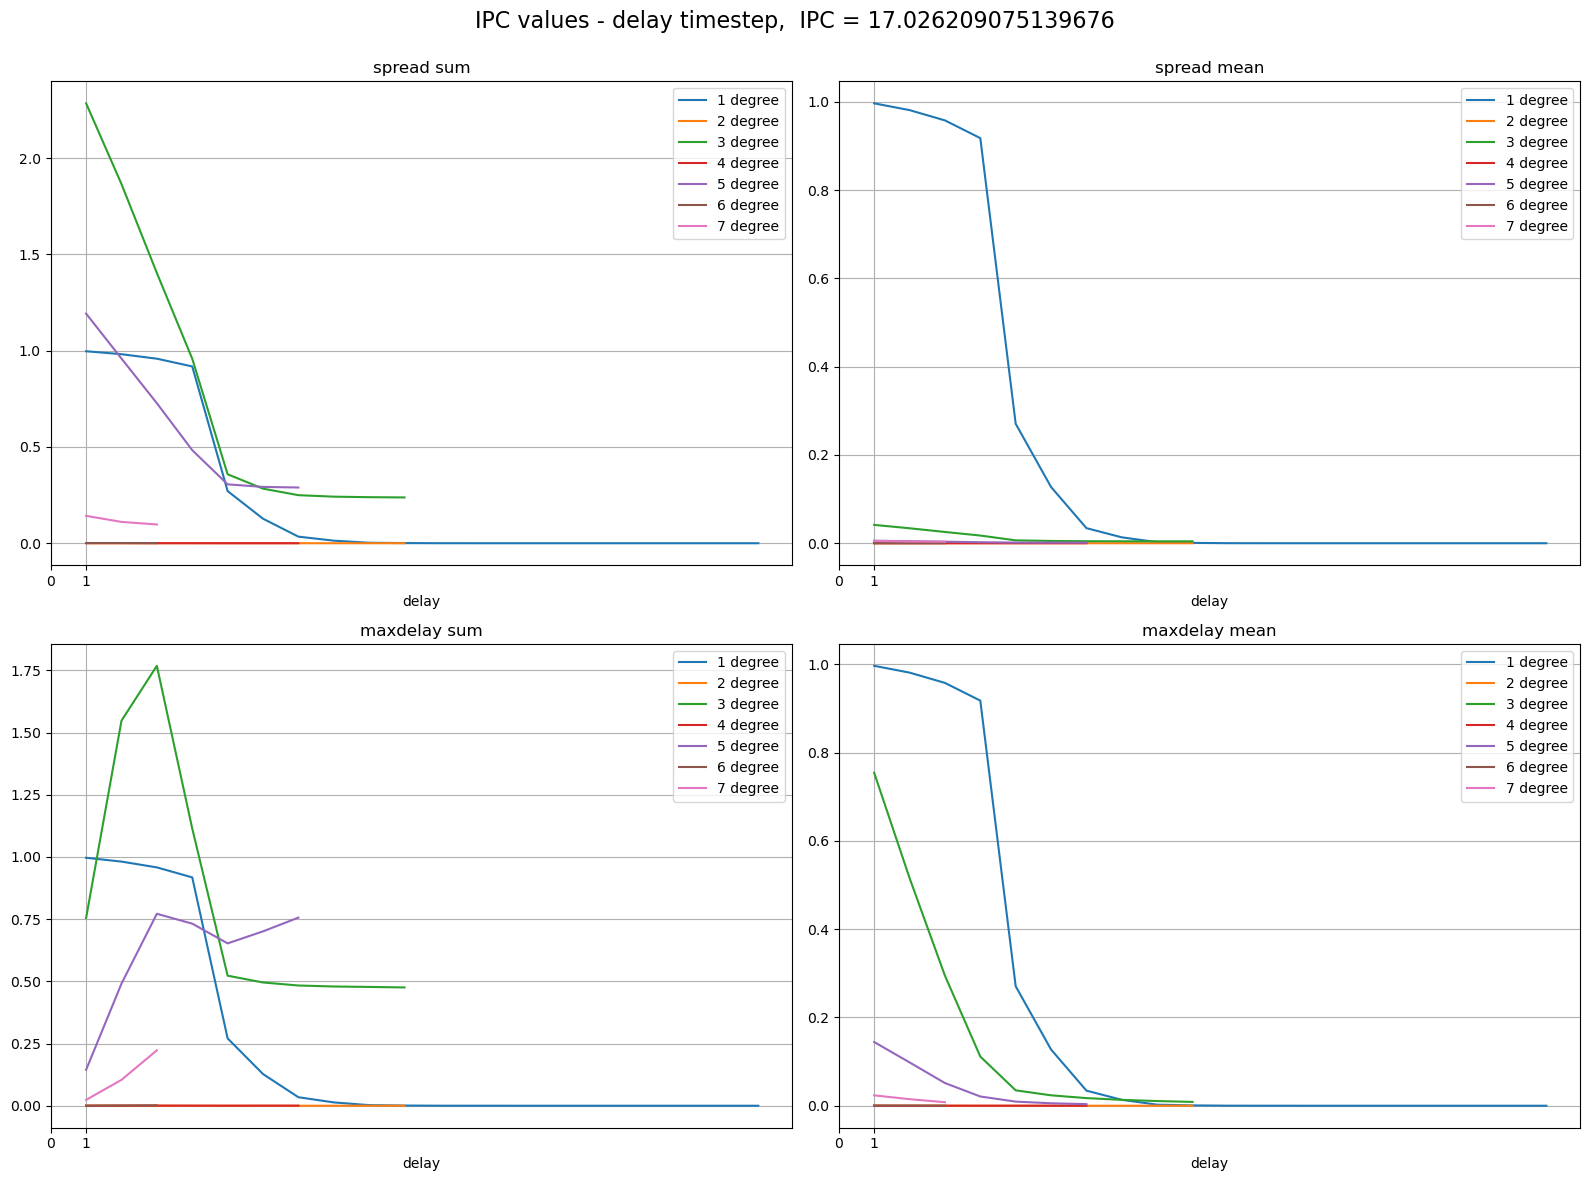

In [6]:
util.ipc_tau_plot(ipc)

In [12]:
print(float(sur))

1.0114554100657405e-05


ipc calc time :0.395 s
1 deg ipc: 4.303387441957684
2 deg ipc: 0.0002705715644705388
3 deg ipc: 8.120038743508664
4 deg ipc: 0.003076193606116482
5 deg ipc: 4.2501497323806685
6 deg ipc: 0.0026677873222175543
7 deg ipc: 0.35030930053590253
total ipc: 17.02989977087572


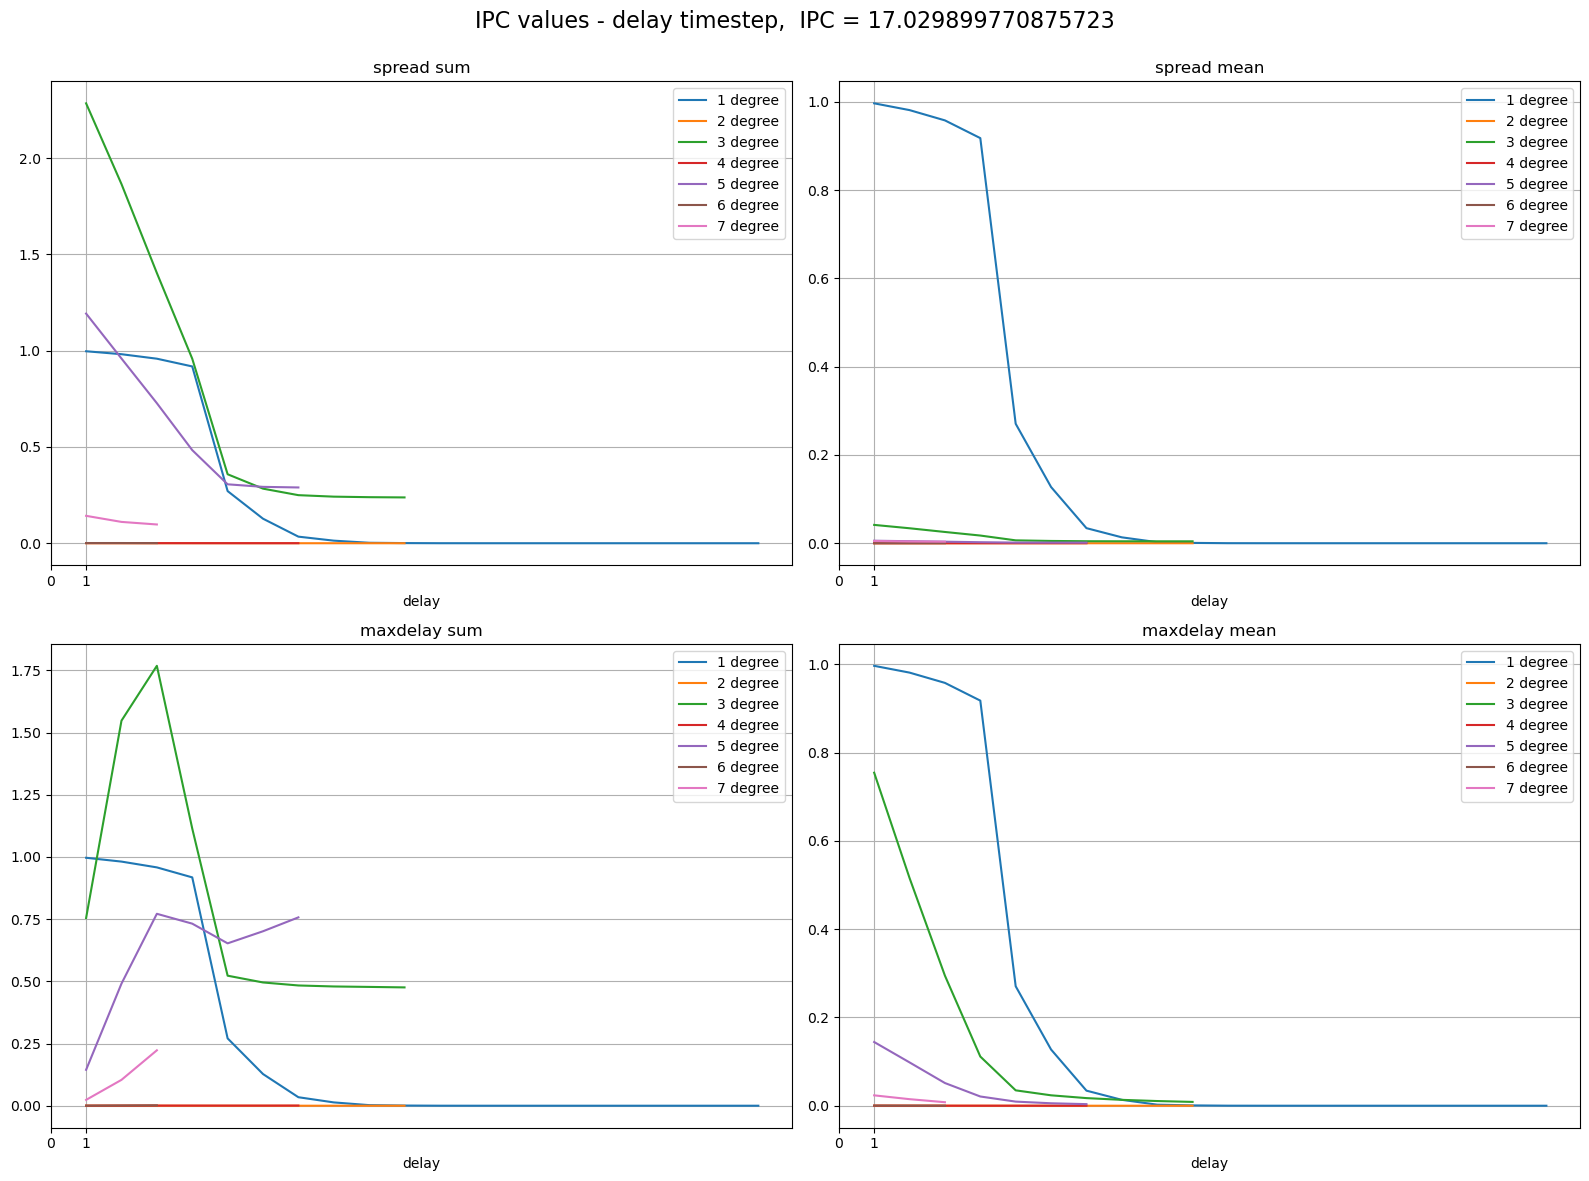

In [32]:
st = time.time()
raw,thr,thr_scl,rev,sur = ESN.calc_capacity(Xwo,ti.tar_f,ret_all=True,thr_scale=1.5)
print(r"ipc calc time :%.3f s"%(time.time()-st))

cap = thr_scl
cap = rev
#cap = raw

ipc=ESN.IPC_w_targetinfo(cap,ti)

util.print_ipc(ipc)
util.ipc_tau_plot(ipc)

In [45]:
ipc_1 = ipc.get_val_by_degree(1)
ipc_3 = ipc.get_val_by_degree(3)
ipc_5 = ipc.get_val_by_degree(5)

"""
1 degree:20 target functions
2 degree:55 target functions
3 degree:220 target functions
4 degree:210 target functions
5 degree:462 target functions
6 degree:28 target functions
7 degree:36 target functions
"""

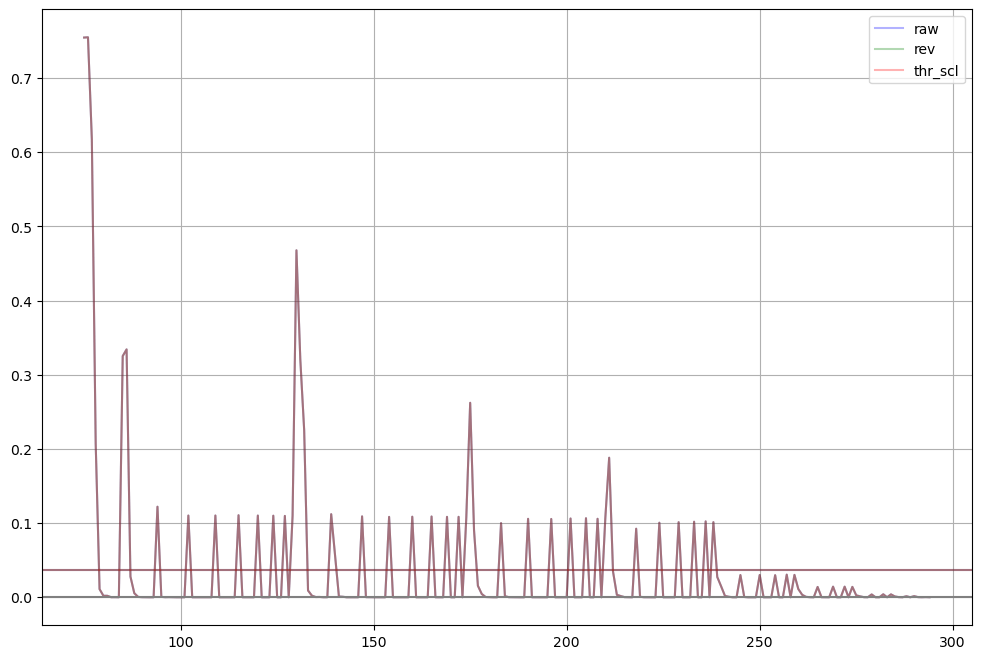

In [49]:
fig,ax = plt.subplots(figsize=(12,8))
stt = 75
end = 295
x=np.arange(len(raw))
alp=0.3

y = raw[stt:end].cpu().numpy()
plt.plot(x[stt:end],y,"b-",alpha=alp,label="raw",)
plt.axhline(np.mean(y),0,40000,c="b",alpha=alp)

y = rev[stt:end].cpu().numpy()
plt.plot(x[stt:end],y,"g-",alpha=alp,label="rev")
plt.axhline(np.mean(y),0,40000,c="g",alpha=alp)

y = thr_scl[stt:end].cpu().numpy()
plt.plot(x[stt:end],y,"r-",alpha=alp,label="thr_scl")
plt.axhline(np.mean(y),0,40000,c="r",alpha=alp)

plt.axhline(sur.cpu().numpy(),0,40000,c="grey")

#plt.ylim(-0.00001,0.0001)
plt.grid(True)
plt.legend()